# 2016-10-14: Nearest neighbors
In this lab, we will apply nearest neighbors classification to the Endometrium vs. Uterus cancer data. For documentation see: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification and http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

Let us start by setting up our environment, loading the data, and setting up our cross-validation.

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Question** Load the data as in the previous lab.

In [2]:
# Load the data as usual (here the code for Python 2.7)
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], 
               converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')

In [46]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)

In [4]:
# This is the cross-validation method with scaling we defined in the previous labs. 
from sklearn import preprocessing
def cross_validate(design_matrix, labels, classifier, cv_folds):
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]

        # Scale data
        scaler = preprocessing.StandardScaler() # create scaler
        Xtr = scaler.fit_transform(Xtr) # fit the scaler to the training data and transform training data
        Xte = scaler.transform(Xte) # transform test data
        
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte)
        pred[te] = yte_pred[:, 1]                
    return pred

**Question** A nearest-neighbors classifier with k neighbors can be instantiated as:
```clf = neighbors.KNeighborsClassifier(n_neighbors=k)```

Cross-validate 15 nearest-neighbors classifiers, for k ranging from 1 to 29 (odd values of k only). Plot the area under the ROC curves you obtained as a function of k. 

Why are we not using even values for k?

Answer : because the aim is to slipt data and if we have two equals parts we can't

In [7]:
from sklearn import neighbors
from sklearn import metrics
aurocs = []

for k in range(1, 30, 2): # values from 1 to 30, with a step size of 2
    # TODO: Compute the vector ypred of cross-validated predictions of a k-nearest-neighbor classifier.
    clf = neighbors.KNeighborsClassifier(k)
    ypred = cross_validate(X, y, clf, folds)

    fpr, tpr, thresholds = metrics.roc_curve(y, ypred, pos_label=1)
    aurocs.append(metrics.auc(fpr, tpr))  

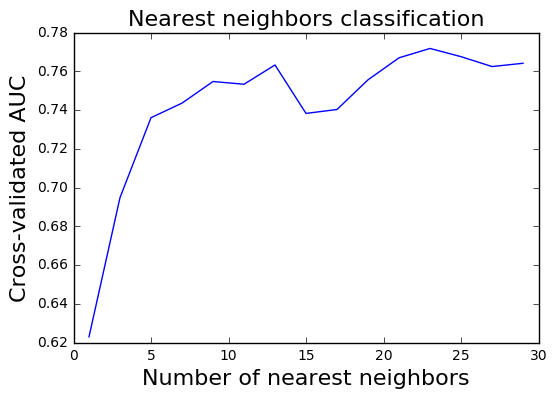

In [8]:
plt.plot(range(1, 30, 2), aurocs, color='blue')
plt.xlabel('Number of nearest neighbors', fontsize=16)
plt.ylabel('Cross-validated AUC', fontsize=16)
plt.title('Nearest neighbors classification', fontsize=16)

**Question** Use 'grid_search.GridSearchCV' to set the optimal value of k automatically. On the previous plot, plot the area under the ROC curve you obtain as a horizontal line.

In [36]:
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
parameters = {
    'n_neighbors': range(1, 30, 2)
}
grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=folds)
grid_search.fit(X, y)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print "\t%s: %r" % (param_name, best_parameters[param_name])

	n_neighbors: 13


**Comment** If the area under the ROC curve is lower than what you were expecting, check the score (i.e. `scoring` parameter) for which the grid search CV parameter was optimized.

Let us look at the optimal value of the parameter k returned for the last fold.

In [33]:
print grid_search.best_params_

{'n_neighbors': 13}


**Question** Modify ```cross_validate(design_matrix, labels, classifier, cv_folds)``` to take as classifier a GridSearchCV instance and print the best parameter(s) for each fold.

In [40]:
def cross_validate_optimize(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn GridSearchCV object
        GridSearchCV instance; must have the following methods/attributes:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        - best_params_ the best parameter dictionary
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vector of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # vector of 0 in which to store the predictions
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape

        # Fit classifier
        classifier.fit(Xtr, ytr)
        print classifier.best_params_

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte) # two-dimensional array
        # Identify the index, in yte_pred, of the positive class (y=1)
        # index_of_class_1 = np.nonzero(classifier.classes_ == 1)[0][0] 
        index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, index_of_class_1]
    return pred

**Question** How many nearest neighbors were chosen for each fold? How stable is this value?
There is one value by fold and no it's not stable

In [41]:
from sklearn import grid_search
param_grid = {'n_neighbors': range(1, 30, 2)}
clf = grid_search.GridSearchCV(neighbors.KNeighborsClassifier(), 
                               param_grid, scoring='roc_auc')
ypred = cross_validate_optimize(X, y, clf, folds)
fpr, tpr, thresholds = metrics.roc_curve(y, ypred, pos_label=1)
auc = metrics.auc(fpr, tpr)

{'n_neighbors': 13}
{'n_neighbors': 17}
{'n_neighbors': 17}
{'n_neighbors': 15}
{'n_neighbors': 9}
{'n_neighbors': 17}
{'n_neighbors': 15}
{'n_neighbors': 15}
{'n_neighbors': 9}
{'n_neighbors': 15}


**Question** How does the nearest-neighbors classifier compare to the linear regression (regularized or not)? Plot ROC curves.
It seems less good than linear regression

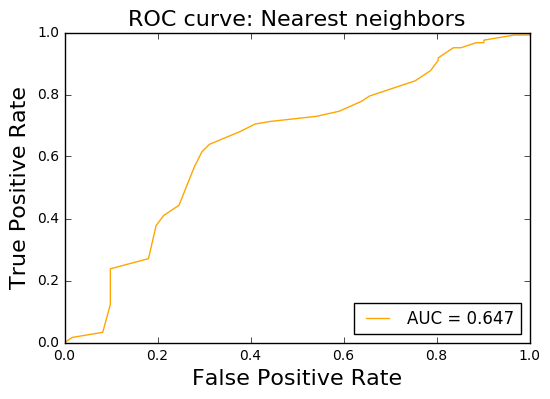

In [39]:
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc
)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Nearest neighbors', fontsize=16)
plt.legend(loc="lower right")

{'n_neighbors': 17, 'p': 2}
{'n_neighbors': 17, 'p': 2}
{'n_neighbors': 15, 'p': 2}
{'n_neighbors': 9, 'p': 2}
{'n_neighbors': 17, 'p': 2}
{'n_neighbors': 17, 'p': 2}
{'n_neighbors': 15, 'p': 2}
{'n_neighbors': 15, 'p': 2}
{'n_neighbors': 15, 'p': 2}
{'n_neighbors': 15, 'p': 2}


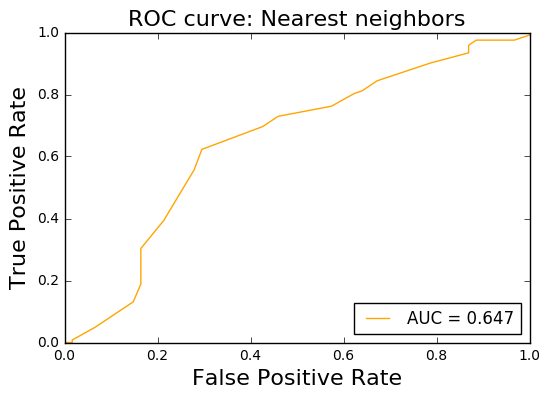

In [49]:
param_grid = {'n_neighbors': range(1, 30, 2),
             'p': [2]}
clf = grid_search.GridSearchCV(neighbors.KNeighborsClassifier(), 
                               param_grid, scoring='roc_auc')
ypred = cross_validate_optimize(X, y, clf, folds)
fpr, tpr, thresholds = metrics.roc_curve(y, ypred, pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc
)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Nearest neighbors', fontsize=16)
plt.legend(loc="lower right")

**Question** What distance was used to define nearest neighbors? What other distances can you use? How does this affect performance?
We used minkowski distance, we can use the euclidean one

## Kaggle challenge
You can find the documentation for nearest neighbors regression here: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression 
* What parameters can you change?
* Cross-validate several different nearest neighbors regressors (different=that use different parameters) on your data, using the folds you previously set up. How do the different variants of nearest neighbors compare to each other? How do they compare to performance obtained with other algorithms?
* Submit predictions to the leaderboard for the best of your nearest-neighbors models. Do the results on the leaderboard data match your expectations?